# Compare missing value imputation methods

on just one target

In [1]:
%load_ext rich

import pathlib
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_error as mae, make_scorer

import seaborn as sns
import matplotlib.pyplot as plt

from collections.abc import Callable

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer

sns.set_context("notebook")
sns.set_palette("colorblind")

In [2]:
basedir = pathlib.Path.home() / "data" / "available_datasets"
df_stream = pd.read_csv(basedir / "stream_nitrogen" / "SINC_input_data_EDI.csv")
df_stream = df_stream[list(sorted(df_stream.columns))]

In [3]:
df_stream.head()

,Datetime,EXO_SpCond_120delta,EXO_SpCond_120h_lag,EXO_SpCond_1delta,EXO_SpCond_1h_lag,EXO_SpCond_1h_median,EXO_SpCond_24delta,EXO_SpCond_24h_lag,EXO_SpCond_5delta,EXO_SpCond_5h_lag,...,SoilMoisture_1delta,SoilMoisture_1h_lag,SoilMoisture_1h_median,SoilMoisture_24delta,SoilMoisture_24h_lag,SoilMoisture_5delta,SoilMoisture_5h_lag,TN,TP,TSP
0,2018-01-22 16:35:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0010,0.1230,0.1240,0.0250,0.0990,0.004,0.1200,0.5512,5.6920,3.5179
1,2018-02-28 15:10:00,24.75075,277.89350,1.01275,301.63150,302.64425,16.33200,286.31225,4.49050,298.15375,...,0.0000,0.1430,0.1430,-0.0045,0.1475,0.000,0.1430,0.3439,7.0481,3.1527
2,2018-03-20 14:10:00,61.96175,392.43450,1.50075,452.89550,454.39625,-2.05325,456.44950,21.43975,432.95650,...,0.0005,0.1260,0.1265,-0.0045,0.1310,-0.001,0.1275,0.6172,12.4426,2.7000
3,2018-04-04 14:00:00,83.58150,173.80875,-5.91025,263.30050,257.39025,-33.04675,290.43700,-25.54325,282.93350,...,0.0010,0.1070,0.1080,0.0080,0.1000,0.005,0.1030,0.4033,10.8230,3.2835
4,2018-04-04 18:00:00,47.61350,165.33275,-13.65900,226.60525,212.94625,-80.21150,293.15775,-50.35425,263.30050,...,0.0045,0.1175,0.1220,0.0200,0.1020,0.015,0.1070,0.4653,30.3826,4.7192


In [4]:
hour_of_day = df_stream["Datetime"].apply(lambda x: x.split(":")[0][-2:]).astype(float)
datetimes = pd.to_datetime(df_stream["Datetime"])
month = df_stream["Datetime"].apply(lambda x: x.split("-")[1]).astype(float)
event = df_stream["Sample_Type"].str.lower().values
site = df_stream["Site"].str.lower().values
for col in ["Site", "Datetime", "Sample_Type"]:
    df_stream.drop(col, axis=1, inplace=True)
target_cols = ["TP", "TSP", "SRP", "TN", "NO3", "NH4", "PP"]
targets = df_stream[target_cols].copy()
y = np.array(targets["PP"])  # Stick to one target
for col in target_cols:
    df_stream.drop(col, axis=1, inplace=True)
df_stream.shape

(680, 63)

In [5]:
targets.isna().sum()


TP     0
TSP    0
SRP    0
TN     0
NO3    0
NH4    0
PP     0
dtype: int64

In [6]:
df_stream.isna().sum().sort_values(ascending=False) / df_stream.shape[0]


EXO_fDOM_120delta        0.404412
EXO_Turb_120delta        0.402941
SoilMoisture_120delta    0.401471
EXO_pH_120delta          0.395588
EXO_Temp_120delta        0.394118
                           ...   
Press_kpa_1h_lag         0.251471
Press_kpa_1h_median      0.251471
Press_kpa_5h_lag         0.248529
Press_kpa_120h_lag       0.244118
Press_kpa_24h_lag        0.238235
Length: 63, dtype: float64

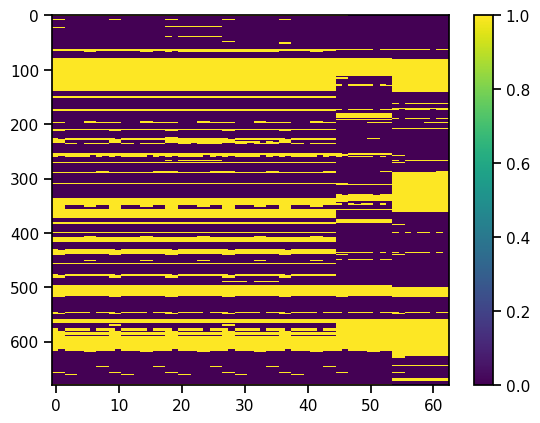

In [7]:
is_missing = df_stream.isna().astype(int)

plt.imshow(is_missing, aspect="auto", interpolation="none")
plt.colorbar()

In [8]:
feats_missing_per_row = pd.DataFrame({
    "perc_feat_missing": df_stream.isna().sum(axis=1) / df_stream.shape[1],
    "event_type": event,
    "site": site, 
    "datetime": datetimes,
    "hod": hour_of_day,
    "moy": month
}).sort_values(by = "perc_feat_missing", ascending=False)
feats_missing_per_row

,perc_feat_missing,event_type,site,datetime,hod,moy
340,1.0,storm event,ts_northwestbay,2017-01-04 20:00:00,20.0,1.0
89,1.0,baseflow,ts_finkle,2016-03-30 17:20:00,17.0,3.0
87,1.0,storm event,ts_finkle,2016-02-25 10:15:00,10.0,2.0
86,1.0,storm event,ts_finkle,2016-02-25 06:15:00,6.0,2.0
85,1.0,storm event,ts_finkle,2016-02-25 02:15:00,2.0,2.0
...,...,...,...,...,...,...
427,0.0,storm event,ts_polehill,2018-10-28 13:59:00,13.0,10.0
425,0.0,storm event,ts_polehill,2018-10-27 16:00:00,16.0,10.0
424,0.0,storm event,ts_polehill,2018-10-27 03:59:00,3.0,10.0
423,0.0,baseflow,ts_polehill,2018-10-18 14:00:00,14.0,10.0


<Axes: xlabel='perc_feat_missing', ylabel='Count'>

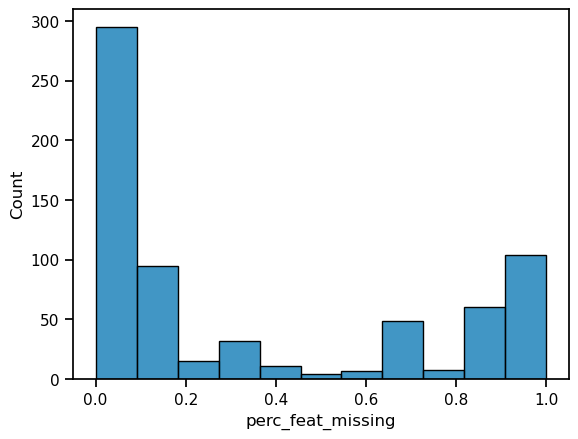

In [9]:
sns.histplot(feats_missing_per_row["perc_feat_missing"])

In [10]:
to_delete = feats_missing_per_row[feats_missing_per_row["perc_feat_missing"] > 0.2].index
df_stream.drop(to_delete, axis=0, inplace=True)
y = np.delete(y, to_delete)

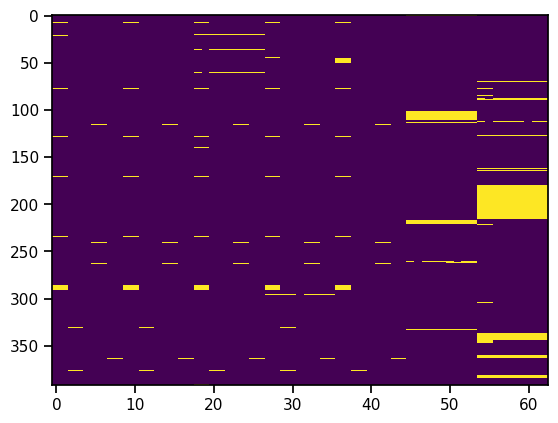

In [11]:
plt.imshow(df_stream.isna().astype(int), aspect="auto", interpolation="none")